# **Дополнительное домашнее задание. Логистическая регрессия и решающие деревья**

Суммарно 10 баллов за всю работу. По 5 баллов в каждой части.

Требуется выполнить следующие задания.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random

from __future__ import annotations

## **Часть 1. Логистическая регрессия (5 баллов)**

**Задание 1 (3 балла)**. Реализуйте логистическую регрессию, обучаемую с помощью двух видов градиенткого спуска:
- полный (по всем данным) градиентный спуск

- стохастический градиентный спуск

Во всех пунктах необходимо соблюдать два условия:
- Циклы можно использовать только для итераций градиентного спуска;
- В качестве критерия останова необходимо использовать (одновременно):

    - проверку на евклидову норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка 1e-6), задаваемого параметром `tolerance`;
    - достижение максимального числа итераций (например, 10000), задаваемого параметром `max_iter`.

Чтобы проследить, что оптимизационный процесс действительно сходится, добавьте атрибут класса `loss_history`. В нём после вызова метода `fit` должны содержаться значения функции потерь для всех итераций градиентного спуска, начиная с нулевой.

Инициализировать веса можно случайным образом или нулевым вектором.

In [2]:
from sklearn.base import BaseEstimator

from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, auc

from sklearn.model_selection import KFold

In [3]:
class MyLogisticRegression(BaseEstimator):
    def __init__(self, gd_type: str = 'stochastic', tolerance: float = 1e-6,
                 max_iter: int = 1000, eta: float = 1e-2,
                 w0: np.array = None) -> None:
        """
        Аргументы:
          gd_type: Вид градиентного спуска ('full' или 'stochastic').

          tolerance: Порог для остановки градиетного спуска.

          max_iter: Максимальное количество шагов в градиентном спуске.

          eta: Скорость обучения (learning rate).

          w0: Массив размерности d (d — количество весов в оптимизации).
              Начальные веса.
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.eta = eta
        self.w0 = w0
        self.w = None
        self.loss_history = None
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))


    def fit(self, X: np.array, y: np.array) -> MyLogisticRegression:
        """Обучаем модель на training данных. Сохраняйте значении функции потерь после каждой итерации.

        Аргументы:
          X: Данные на обучение.

          y: Целевая переменная.

        Возвращает:
          self: Обученный регрессор.
        """
        self.loss_history = []
        n_features = X.shape[1]
        self.w = np.zeros(n_features) if self.w0 is None else self.w0

        for i in range(self.max_iter):
            if self.gd_type == 'stochastic':
                for j in range(len(y)):
                    idx = np.random.randint(0, len(y))
                    X_sample, y_sample = X[idx:idx+1], y[idx:idx+1]
                    gradient = self.calc_gradient(X_sample, y_sample)
                    self.w -= self.eta * gradient
            else:
                gradient = self.calc_gradient(X, y)
                w_prev = self.w.copy()
                self.w -= self.eta * gradient

                if np.linalg.norm(self.w - w_prev) < self.tolerance:
                    break

            self.loss_history.append(self.calc_loss(X, y))

        return self


    def predict_proba(self, X: np.array) -> np.array:
        """Вычислите вероятности положительного и отрицательного классов для каждого наблюдения.

        Аргументы:
          X: Массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n, 2).
             Предсказанные вероятности.
        """
        if self.w is None:
            raise Exception('Not trained yet')
        return self.sigmoid(X @ self.w)


    def predict(self, X: np.array) -> np.array:
        """Предсказание метки класса для каждого наблюдения.

        Аргументы:
          X: Массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n,).
             Предсказанные метки классов.
        """
        if self.w is None:
            raise Exception('Not trained yet')
        return (self.predict_proba(X) >= 0.5).astype(int)


    def calc_gradient(self, X: np.array, y: np.array) -> np.array:
        """Вычислите градиент функции потерь после каждой итерации.

        Аргументы:
          X: Массив размером (n, d), n может быть равно 1, если выбран 'stochastic'.
          y: Массив размером (n,).

        Возвращает:
          Массив размером (d,).
          Градиент функции потерь после текущей итерации.
        """
        m = len(y)
        predictions = self.sigmoid(X @ self.w)
        error = predictions - y
        grad = X.T @ error / m
        return grad


    def calc_loss(self, X: np.array, y: np.array) -> float:
        """Вычислите значение функции потерь после каждой итерации.

        Аргументы:
          X: Массив размером (n, d).
          y: Массив размером (n,).

        Возвращает:
          Значение функции потерь после текущей итерации.
        """
        m = len(y)
        predictions = self.sigmoid(X @ self.w)
        return -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))

Далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

Сгенерируем искусственные данные.

In [4]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=999)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=999)

**Задание 2 (1 балл).** Обучите логистическую регрессию на искусственных данных. Нарисуйте изменение лосса во время обучения.

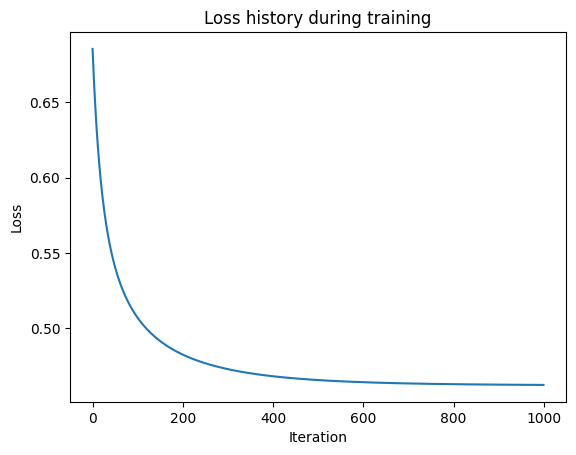

In [5]:
model = MyLogisticRegression(gd_type='full', max_iter=1000, eta=0.01)
model.fit(X_train, y_train)

# Plot the loss history
plt.plot(model.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss history during training')
plt.show()

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые.

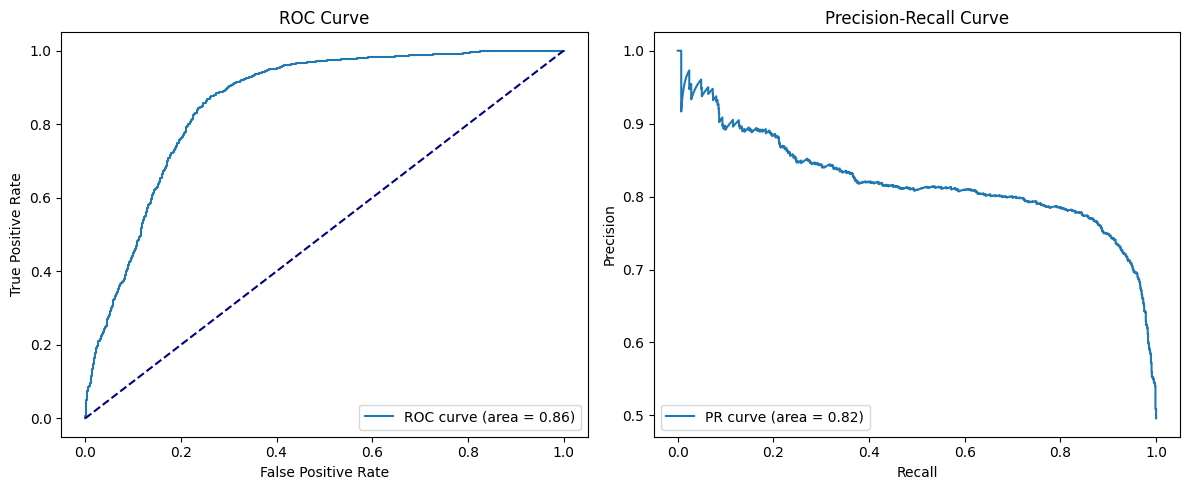

In [6]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc


probabilities = model.predict_proba(X_test)

roc_auc = roc_auc_score(y_test, probabilities)
precision, recall, _ = precision_recall_curve(y_test, probabilities)
pr_auc = auc(recall, precision)

fpr, tpr, _ = roc_curve(y_test, probabilities)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

**Задание 3 (1 балл).** Оцените ошибку ROC-AUC и PR-AUC вашей модели при помощи K-fold кросс валидации.  

In [7]:
def evaluate_model(X, y, model, n_splits=5):
    kf = KFold(n_splits=n_splits)
    roc_auc_scores = []
    pr_auc_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        probabilities = model.predict_proba(X_test)

        roc_auc = roc_auc_score(y_test, probabilities)
        precision, recall, _ = precision_recall_curve(y_test, probabilities)
        pr_auc = auc(recall, precision)

        roc_auc_scores.append(roc_auc)
        pr_auc_scores.append(pr_auc)

    return roc_auc_scores, pr_auc_scores


roc_auc_scores, pr_auc_scores = evaluate_model(X, y, MyLogisticRegression(gd_type='full', max_iter=1000, eta=0.01))


mean_roc_auc = np.mean(roc_auc_scores)
std_roc_auc = np.std(roc_auc_scores)
mean_pr_auc = np.mean(pr_auc_scores)
std_pr_auc = np.std(pr_auc_scores)


print(f"Mean ROC-AUC: {mean_roc_auc:.4f}")
print(f"Standard Deviation of ROC-AUC: {std_roc_auc:.4f}")
print(f"Mean PR-AUC: {mean_pr_auc:.4f}")
print(f"Standard Deviation of PR-AUC: {std_pr_auc:.4f}")

Mean ROC-AUC: 0.8610
Standard Deviation of ROC-AUC: 0.0054
Mean PR-AUC: 0.8323
Standard Deviation of PR-AUC: 0.0077


## **Часть 2. Решающие деревья (5 баллов)**

Здесь требуется реализовать разбиение элементов выборки в вершине дерева.

$R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения.

Критерий ошибки:

$$
Q(R_m, j, t) = \frac{|R_\ell|}{|R_m|}H(R_\ell) + \frac{|R_r|}{|R_m|}H(R_r) \to \min_{j, t}
$$

$R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

$H(R)$ - критерий информативности, с помощью которого можно оценить качество распределения целевой переменной среди объектов множества $R$.

In [8]:
from typing import Iterable, List, Tuple

Так как Boston Dataset с недавних пор отсутствует в sklearn, то ниже реализован способ загрузки данного датасета из другого источника.

In [9]:
# `load_boston` has been removed from scikit-learn since version 1.2.

#from sklearn.datasets import load_boston
#boston = load_boston()

In [10]:
# !wget -i https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/datasets/data/boston_house_prices.csv
#data_git = pd.read_csv('boston_house_prices.csv', sep="\s+")

**Data Set Characteristics:**  

    :Number of Instances: 506

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's

    :Missing Attribute Values: None

    :Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of UCI ML housing dataset.
https://archive.ics.uci.edu/ml/machine-learning-databases/housing/

This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.

The Boston house-price data has been used in many machine learning papers that address regression
problems.   
     
.. topic:: References

   - Belsley, Kuh & Welsch, 'Regression diagnostics: Identifying Influential Data and Sources of Collinearity', Wiley, 1980. 244-261.
   - Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.



In [9]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [10]:
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

X = pd.DataFrame(data, columns=feature_names, index=range(len(data)))
y = pd.DataFrame(target, columns=['MEDV'], index=range(len(target)))

X['target'] = y

In [11]:
X_train, X_test = train_test_split(X, test_size=0.25, random_state=999)

**Задание 1 (1 балл)**. Реализуйте подсчет критерия ошибки. Для этого реализуйте функции для подсчета значения критерия информативности, а также для разбиения вершины.

In [12]:
def H(R):
    """
    Вычислить критерий информативности (impurity criterion) для фиксированного набора объектов R.
    Предполагается, что последний столбец содержит целевую переменную.
    """
    if len(R) == 0:
        return 0
    target = R[:, -1]
    mean_target = np.mean(target)
    mse = np.mean((target - mean_target) ** 2)
    return mse

def split_node(R_m, feature, t):
    """
    Разделить фиксированный набор объектов R_m с заданным признаком (номером признака) и пороговым значением t.
    """
    left = R_m[R_m[:, feature] <= t]
    right = R_m[R_m[:, feature] > t]
    return left, right

def q_error(R_m, feature, t):
    """
    Вычислить критерий ошибки для заданных параметров разделения.
    """
    left, right = split_node(R_m, feature, t)
    H_left = H(left)
    H_right = H(right)
    return (len(left) / len(R_m)) * H_left + (len(right) / len(R_m)) * H_right


**Задание 2 (1 балл)**. Переберите все возможные разбиения обучающей выборки по одному из признаков и постройте график критерия ошибки в зависимости от значения порога.

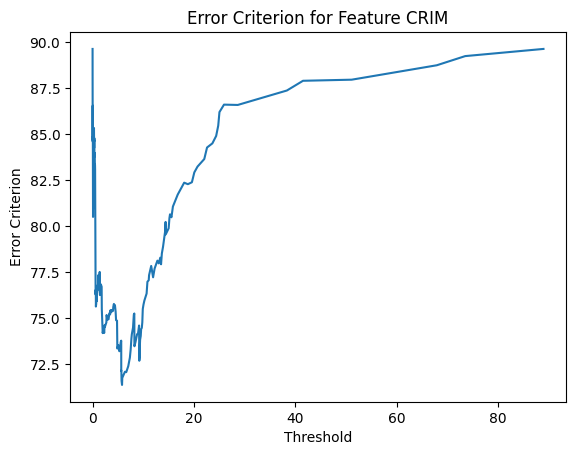

In [13]:
# Выбор признака (например, первый признак)
feature_index = 0

# Уникальные значения выбранного признака
thresholds = np.unique(X_train.iloc[:, feature_index])

# Копируем DataFrame
R_m = X_train.copy()

# Список для хранения значений критерия ошибки
errors = []

# Перебор всех возможных пороговых значений
for t in thresholds:
    error = q_error(R_m.to_numpy(), feature_index, t)
    errors.append(error)

# Построение графика
plt.plot(thresholds, errors)
plt.xlabel('Threshold')
plt.ylabel('Error Criterion')
plt.title(f'Error Criterion for Feature {X_train.columns[feature_index]}')
plt.show()

**Задание 3  (1 балл)**. Напишите функцию, находящую оптимальное разбиение данной вершины по данному признаку.

In [14]:
def get_optimal_split(R_m: np.array, feature: str) -> Tuple[float, List[float]]:
    thresholds = np.unique(R_m[:, feature])
    best_t = None
    min_error = float('inf')
    errors = []

    for t in thresholds:
        error = q_error(R_m, feature, t)
        errors.append(error)
        if error < min_error:
            min_error = error
            best_t = t

    return best_t, errors

# Пример использования функции (используя первый признак и его индекс из предыдущего примера)
optimal_threshold, errors = get_optimal_split(R_m.to_numpy(), feature_index)
optimal_threshold, errors[:5]  # Выведем первые 5 значений ошибок для примера

(5.82401,
 [89.61374851670367,
  89.4914890154882,
  89.58262888527106,
  88.94333612235971,
  88.16822687284396])

**Задание 4  (1 балл)**. Для первого разбиения найдите признак, показывающий наилучшее качество. Каков порог разбиения и значение качества? Постройте график критерия ошибки для данного признака в зависимости от значения порога.

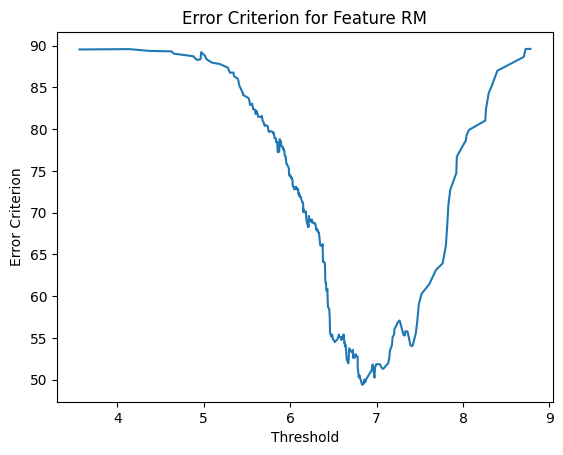

Best treshold: 6.833
Best error: 49.381


In [15]:
# Нахождение признака с наилучшим качеством разбиения для первого разбиения

best_feature_index = None
best_threshold = None
best_error = float('inf')
best_errors = []

num_features = R_m.shape[1] - 1  # Исключаем столбец с целевой переменной

for feature_index in range(num_features):
    threshold, errors = get_optimal_split(R_m.to_numpy(), feature_index)
    min_error = min(errors)
    if min_error < best_error:
        best_error = min_error
        best_threshold = threshold
        best_feature_index = feature_index
        best_errors = errors

best_feature_name = X_train.columns[best_feature_index]

# Построение графика критерия ошибки для наилучшего признака
plt.plot(np.unique(R_m.iloc[:, best_feature_index]), best_errors)
plt.xlabel('Threshold')
plt.ylabel('Error Criterion')
plt.title(f'Error Criterion for Feature {best_feature_name}')
plt.show()

print(f'Best treshold: {best_threshold}')
print(f'Best error: {best_error.round(3)}')

 **Задание 5 (1 балл)**. Изобразите разбиение визуально. Для этого постройте диаграмму рассеяния целевой переменной в зависимости от значения входного признака. Далее изобразите вертикальную линию, соответствующую порогу разбиения.

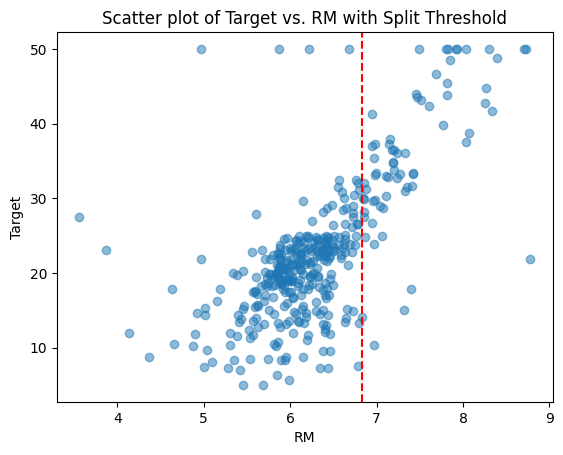

In [16]:
y_train_tree = X_train['target']
plt.scatter(X_train[best_feature_name], y_train_tree, alpha=0.5)
plt.axvline(x=best_threshold, color='r', linestyle='--')
plt.xlabel(best_feature_name)
plt.ylabel('Target')
plt.title(f'Scatter plot of Target vs. {best_feature_name} with Split Threshold')
plt.show()